# Recommender systems project

Nazariy Vysokinskyi, Dmytro Ponomarov, Maksym Sarana

### Exploratory Data Analysis

The exploratory data analysis is in this document in the [Appendix A](#appendix_A_exploratory_data_analysis).

### Development & Experiment Journal

#### Repo structure

- [`data/`](data) - directory with original data, files with train and test ids, external data
- [`models/`](models) - directory includes an abstract model class and implementation of the models
- [`evaluation/`](evaluation) - directory includes the Evaluation Framework class and a file with data prepocessing functions
- [`task/`](task) - directory with the original task description
- [`run.py`](run.py) - CLI to run the Evaluation Framework
- [`requirements.txt`](requirements.txt) - Python reqirements
- [`report.ipynb`](report.ipynb) - current document as a jupyter notebook
- [`report.html`](report.html) - current document as an HTML file
- [`README.md`](README.md) - repo readme file

### Comparison of models and approaches

### Summary & Conclusions

<a id='appendix_A_exploratory_data_analysis'></a>
# Appendix A. Exploratory data analysis

In [221]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from datetime import datetime
import re
import matplotlib.pyplot as plt

Note: the notebook expects the `PYTHONPATH` variable is set to the root of the repository

In [222]:
from evaluation.read_data import read_movies, read_ratings, read_users
from evaluation.read_data import get_user_age, get_user_occupation
from evaluation.read_data import encode_movie_genres, extract_movie_year, get_rating_datetime

Read data

In [223]:
users = read_users('../data/users.dat')
movies = read_movies('../data/movies.dat')
ratings = read_ratings('../data/ratings.dat')

In [224]:
print('Number of users:', users.shape[0])
print('Number of movies:', movies.shape[0])
print('Number of ratings:', ratings.shape[0])

Number of users: 6040
Number of movies: 3883
Number of ratings: 1000209


## 1-1. Users analysis

Process data, extract additional info

In [225]:
users_mod = users.join(get_user_age(), on='Age').join(get_user_occupation(), on='Occupation')

In [226]:
users_mod.head()

,UserID,Gender,Age,Occupation,ZipCode,AgeGroup,OccupationDetailed
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


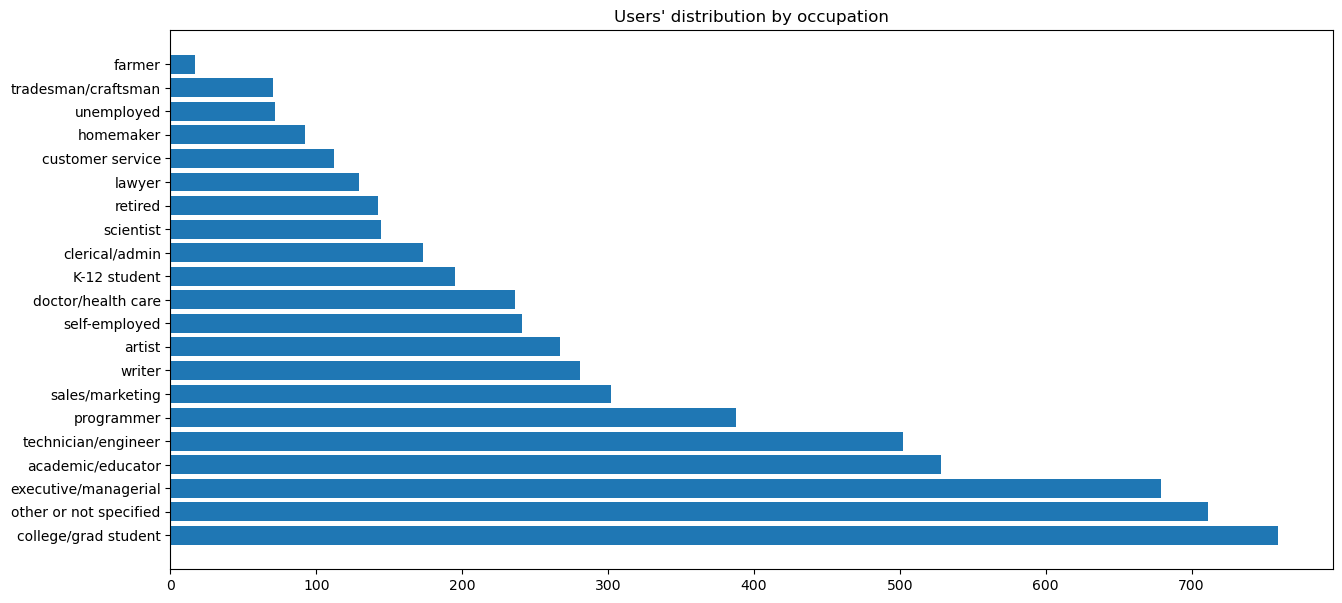

In [227]:
plt.figure(figsize=(15, 7))
plt.title("Users' distribution by occupation")
occupation_stats = users_mod.OccupationDetailed.value_counts()
plt.barh(y=occupation_stats.index, width=occupation_stats);

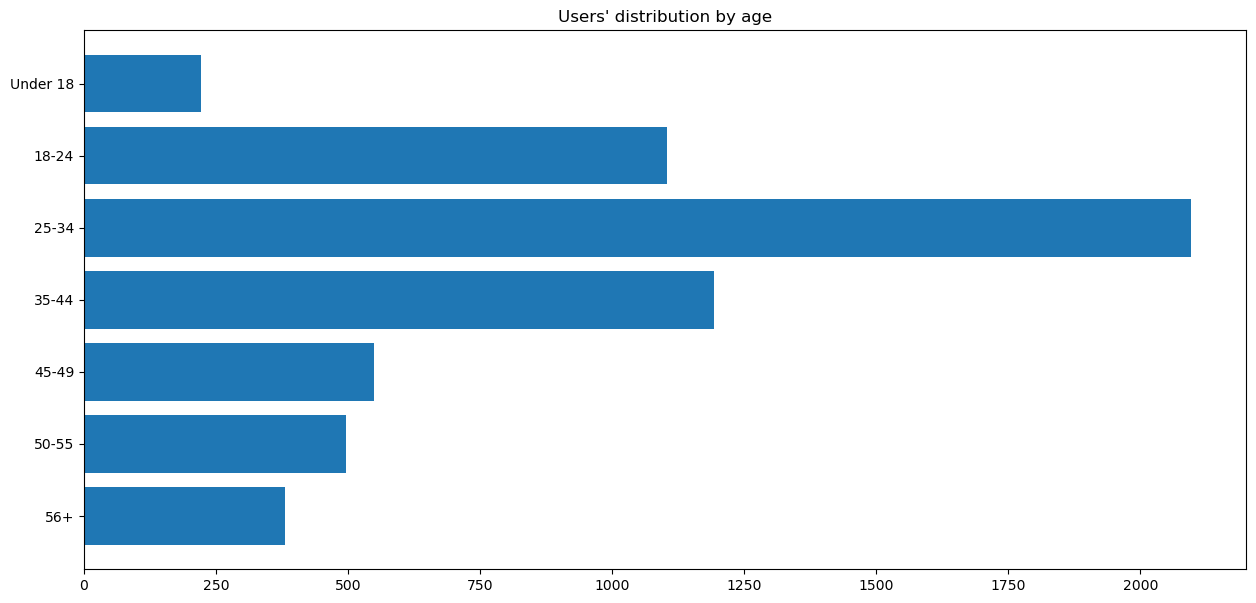

In [228]:
plt.figure(figsize=(15, 7))
plt.title("Users' distribution by age")
age_stats = users_mod.AgeGroup.value_counts()
age_stats = age_stats.reindex(get_user_age().to_list()[::-1])
plt.barh(y=age_stats.index, width=age_stats);

## 1-2. Movies analysis

In [229]:
movies_mod = extract_movie_year(encode_movie_genres(movies, drop_genres_column=True), remove_year_from_title=True)

In [230]:
movies_mod.head()

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
0,1,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


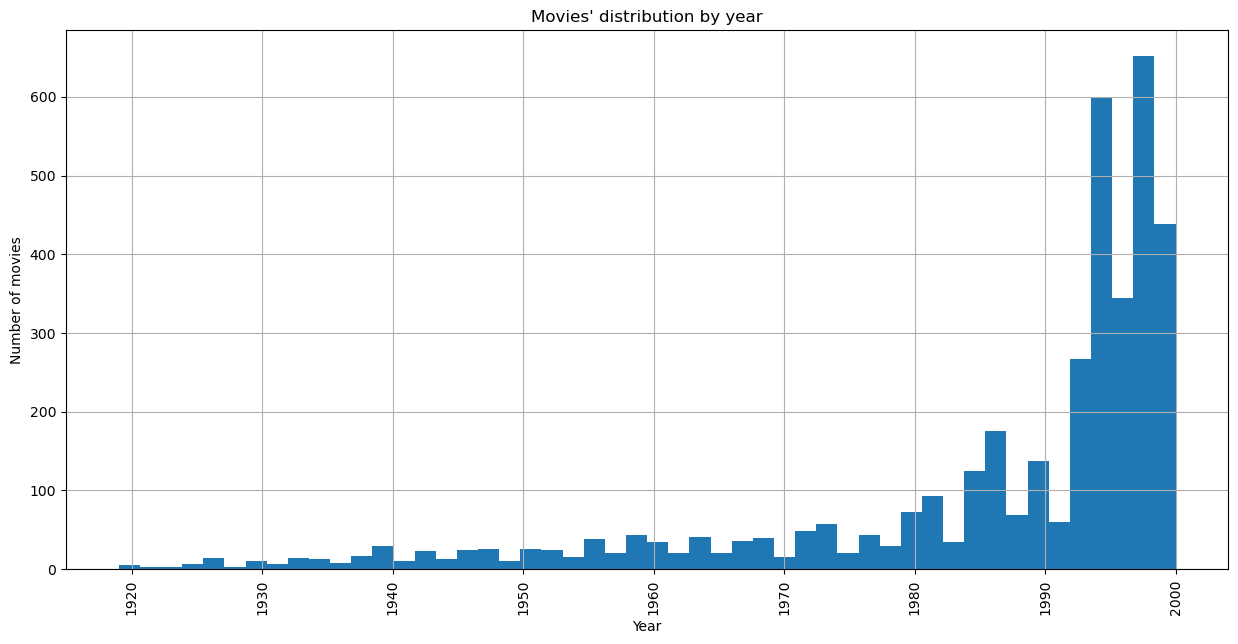

In [231]:
plt.figure(figsize=(15, 7))
plt.title("Movies' distribution by year")
plt.xlabel('Year')
plt.ylabel('Number of movies')
movies_mod.Year.hist(bins=50);
plt.xticks(rotation=90);

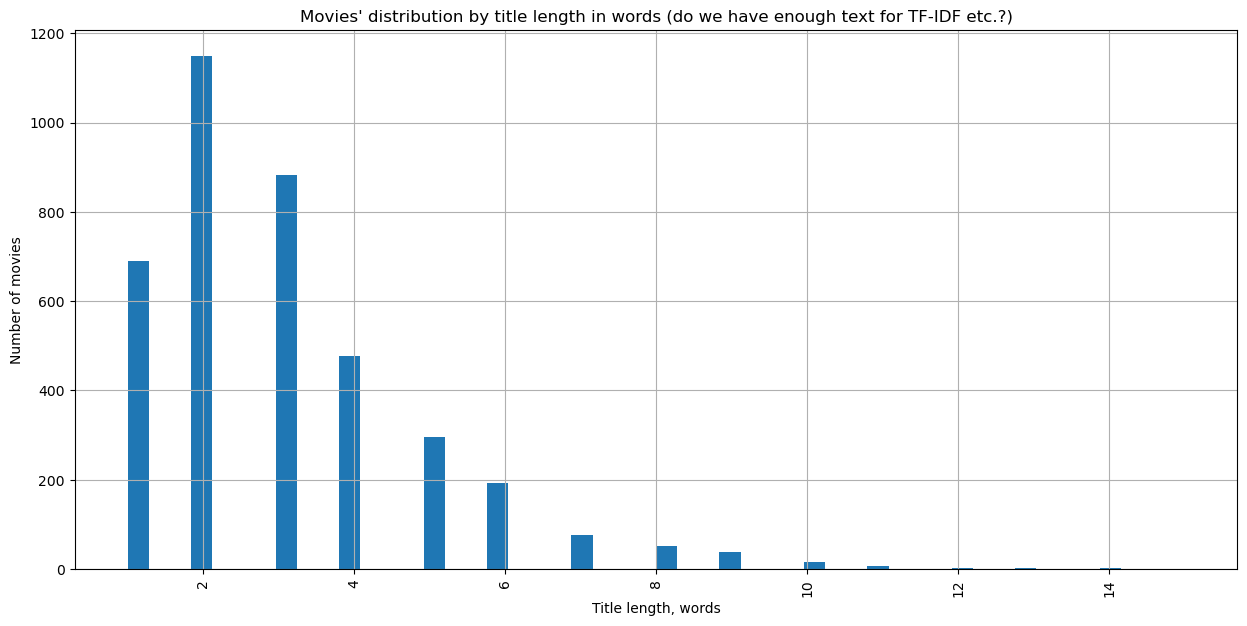

In [232]:
plt.figure(figsize=(15, 7))
plt.title("Movies' distribution by title length in words (do we have enough text for TF-IDF etc.?)")
plt.xlabel('Title length, words')
plt.ylabel('Number of movies')
movies_mod.Title.map(lambda x: len(x.split())).hist(bins=50);
plt.xticks(rotation=90);

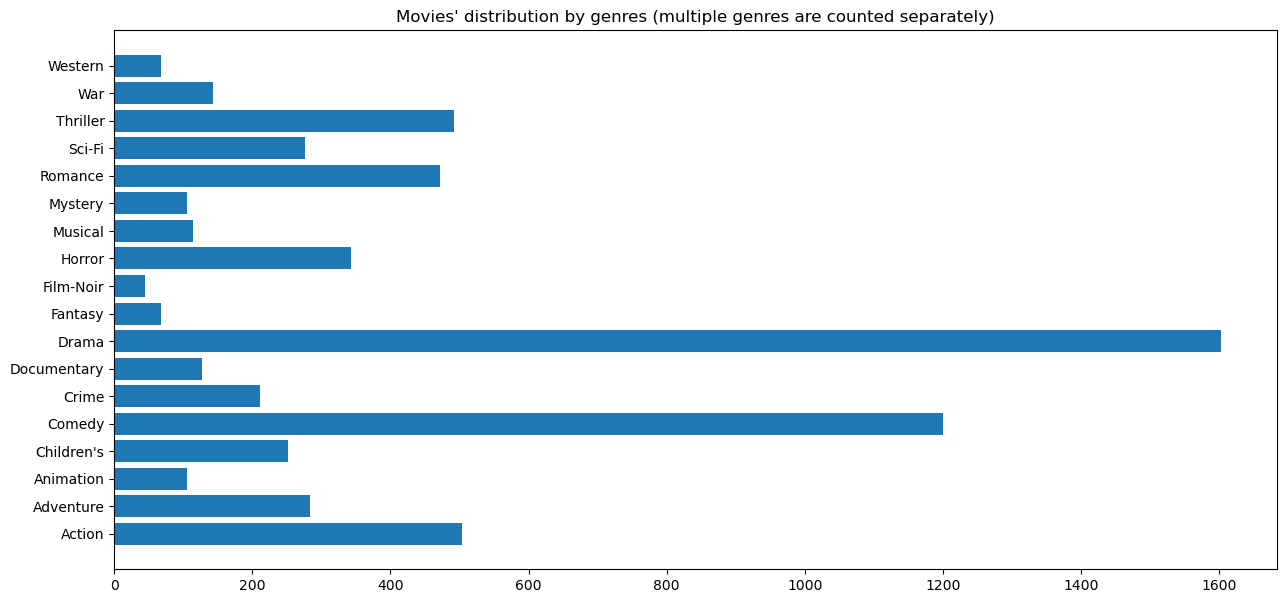

In [233]:
plt.figure(figsize=(15, 7))
plt.title("Movies' distribution by genres (multiple genres are counted separately)")
genres_sums = movies_mod[[x for x in movies_mod.columns if x.startswith('Genre_')]].sum()
plt.barh(y=genres_sums.index.map(lambda x: x.split("_", maxsplit=1)[1]), width=genres_sums);

## 1-3. Ratings analysis

Process data, extract additional info

In [234]:
ratings_mod = get_rating_datetime(ratings, remove_timestamp_column=False)

In [235]:
ratings_mod.head()

,UserID,MovieID,Rating,Timestamp,DateTime
0,1,1193,5,978300760,2001-01-01 00:12:40
1,1,661,3,978302109,2001-01-01 00:35:09
2,1,914,3,978301968,2001-01-01 00:32:48
3,1,3408,4,978300275,2001-01-01 00:04:35
4,1,2355,5,978824291,2001-01-07 01:38:11


Distribution in time:

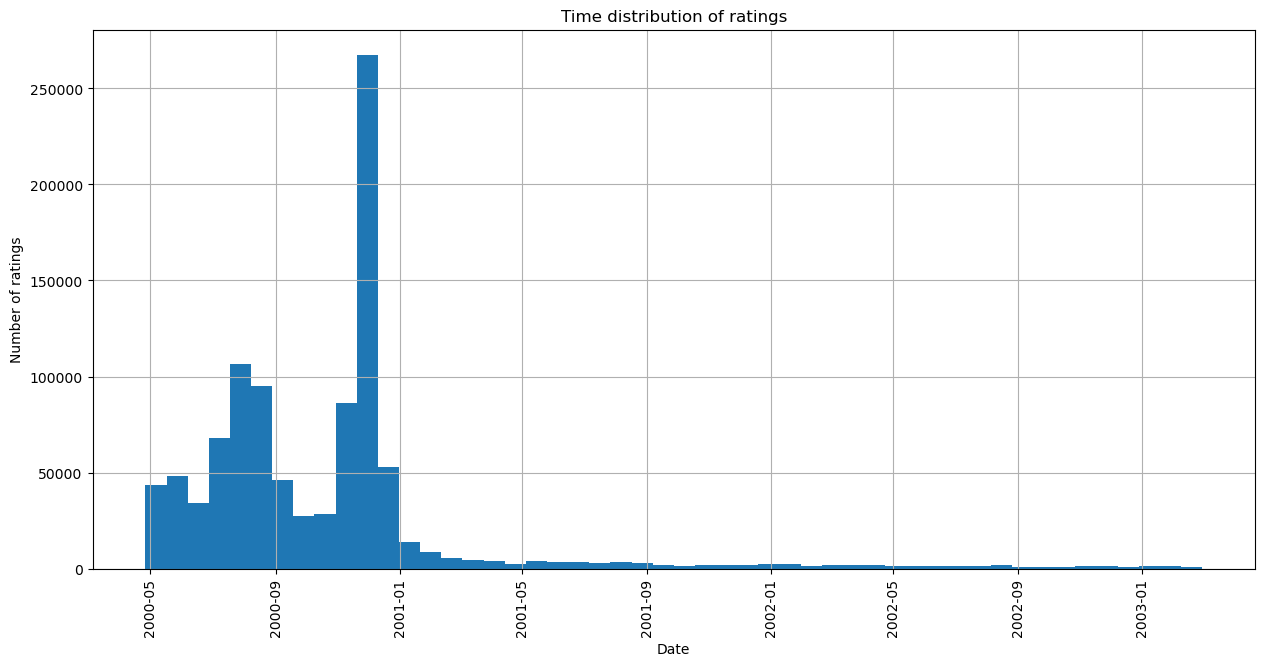

In [16]:
plt.figure(figsize=(15, 7))
plt.title("Time distribution of ratings")
plt.xlabel('Date')
plt.ylabel('Number of ratings')
ratings_mod.DateTime.hist(bins=50)
plt.xticks(rotation=90);

Distribution of a number of ratings per user and per movie:

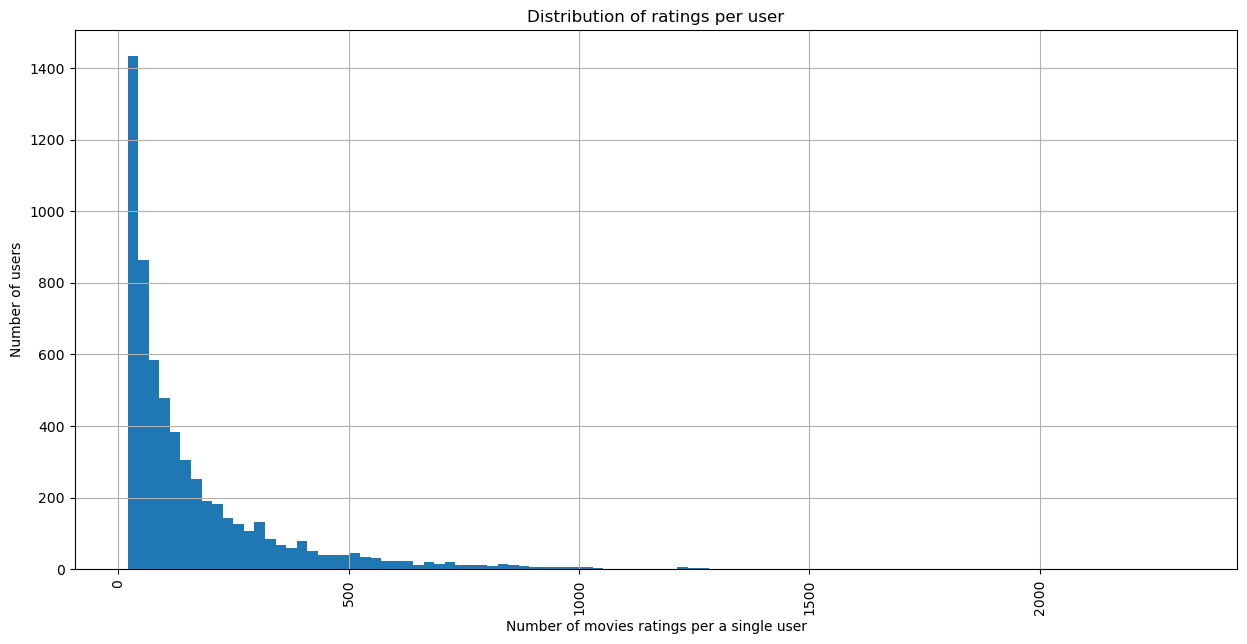

In [17]:
plt.figure(figsize=(15, 7))
plt.title("Distribution of ratings per user")
plt.xlabel('Number of movies ratings per a single user')
plt.ylabel('Number of users')
ratings_mod.groupby('UserID')['MovieID'].count().hist(bins=100)
plt.xticks(rotation=90);

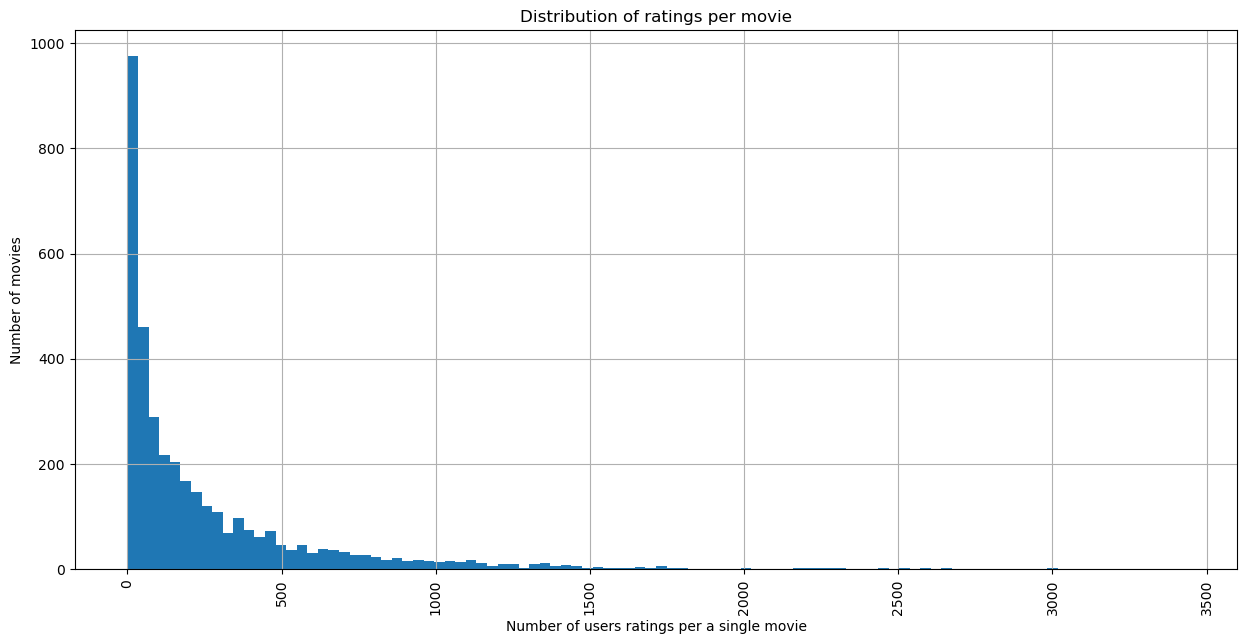

In [18]:
plt.figure(figsize=(15, 7))
plt.title("Distribution of ratings per movie")
plt.xlabel('Number of users ratings per a single movie')
plt.ylabel('Number of movies')
ratings_mod.groupby('MovieID')['UserID'].count().hist(bins=100)
plt.xticks(rotation=90);

Do we have doubled rating for the same users and movies?

In [19]:
ratings_mod.groupby(['UserID', 'MovieID'])['Rating'].count().max() > 1

False

How the new user acquisition is distributed in time?

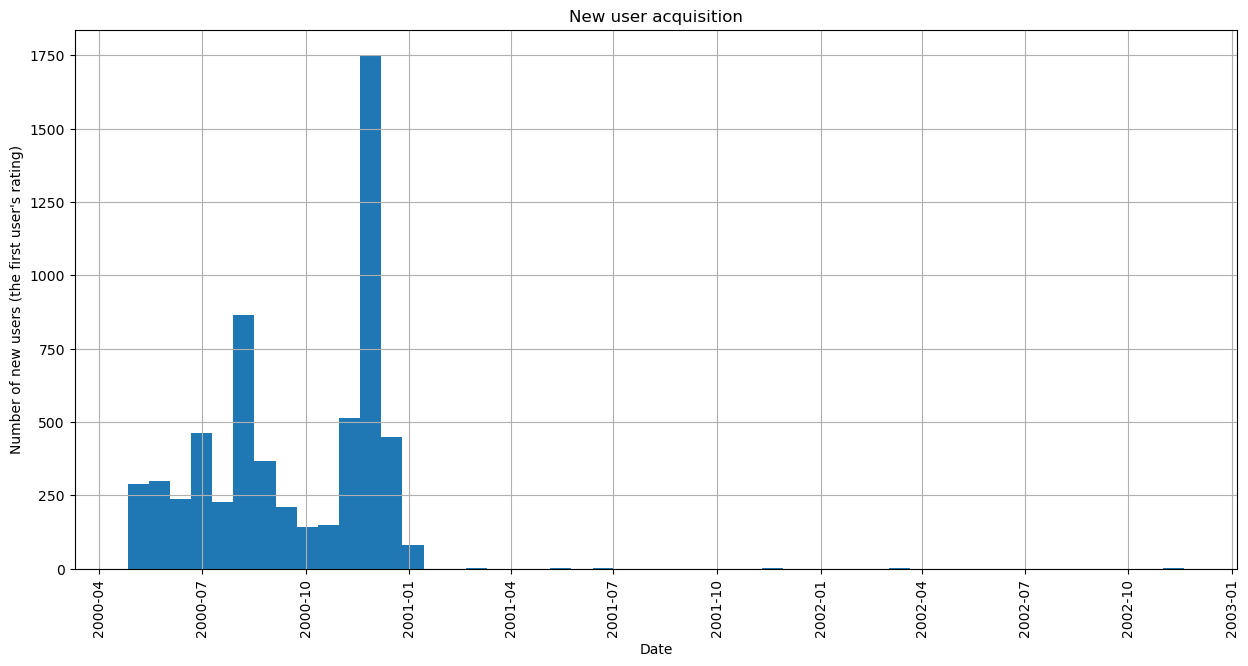

In [20]:
plt.figure(figsize=(15, 7))
plt.title("New user acquisition")
plt.xlabel('Date')
plt.ylabel("Number of new users (the first user's rating)")
ratings_mod.groupby('UserID')['DateTime'].min().hist(bins=50)
plt.xticks(rotation=90);

And with more bins:

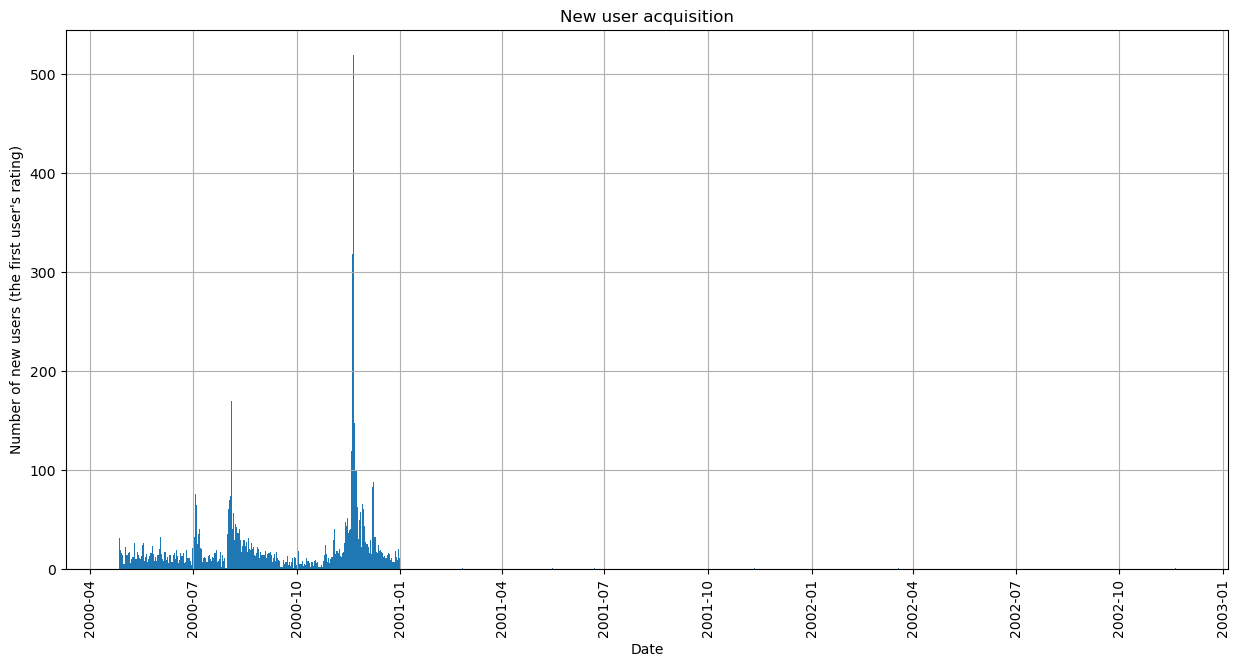

In [21]:
plt.figure(figsize=(15, 7))
plt.title("New user acquisition")
plt.xlabel('Date')
plt.ylabel("Number of new users (the first user's rating)")
ratings_mod.groupby('UserID')['DateTime'].min().hist(bins=1000)
plt.xticks(rotation=90);

Let's find a median (to remove the outliers) number of new users aquired in the active period (from May-2000 till December-2000):

In [22]:
filter_range = (datetime.strptime("2000-05-01T00:00:00", "%Y-%m-%dT%H:%M:%S"), datetime.strptime("2001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S"))

ratings_filtered = ratings_mod[ratings_mod.DateTime.map(lambda x: filter_range[0] <= x < filter_range[1])]

users_first_ratings = ratings_filtered.groupby('UserID').min()[['DateTime']]
users_first_ratings['Date'] = users_first_ratings.DateTime.map(lambda x: x.date())

users_first_ratings.groupby('Date').count().median()

DateTime    15.0
dtype: float64

# Train/test split

In [23]:
test_set_threshold = datetime.strptime("2000-11-23T00:00:00", "%Y-%m-%dT%H:%M:%S")

test_index = ratings_mod.DateTime >= test_set_threshold

train_ratings = ratings_mod.loc[~test_index]
test_ratings = ratings_mod.loc[test_index]

print(f'Train set: {train_ratings.shape[0]} ratings, {train_ratings.shape[0] / ratings_mod.shape[0]:.2%}')
print(f'Test set: {test_ratings.shape[0]} ratings, {test_ratings.shape[0] / ratings_mod.shape[0]:.2%}')

Train set: 715114 ratings, 71.50%
Test set: 285095 ratings, 28.50%


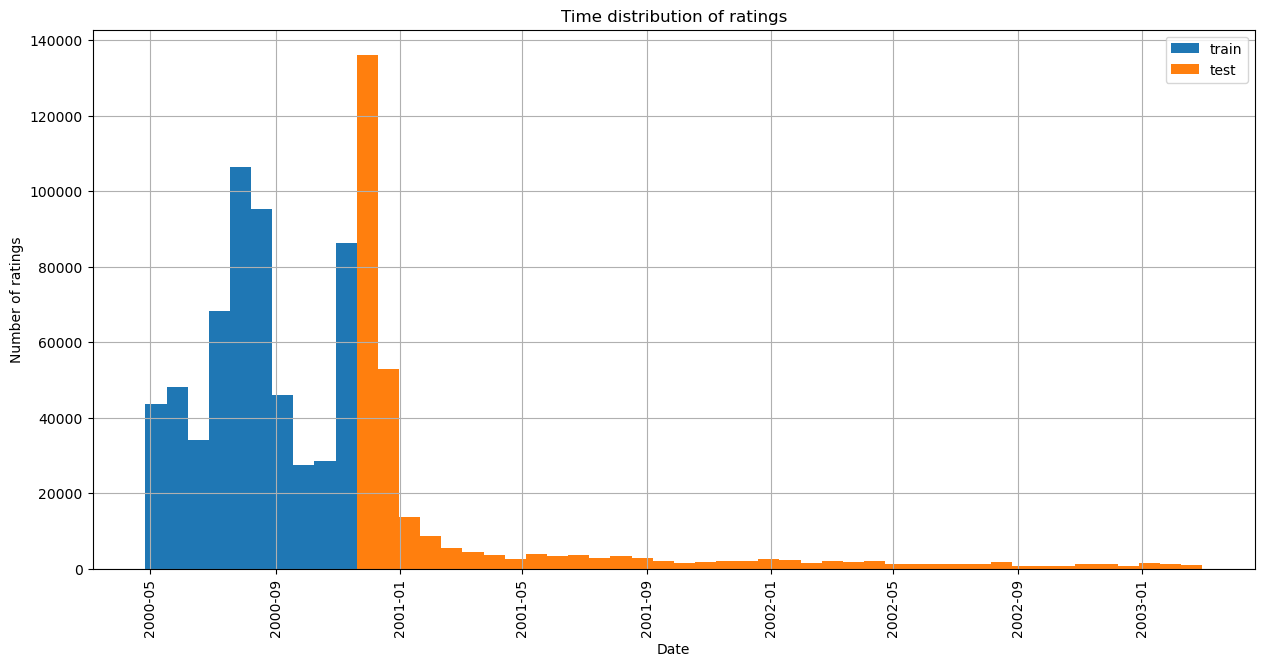

In [24]:
plt.figure(figsize=(15, 7))
plt.title("Time distribution of ratings")
plt.xlabel('Date')
plt.ylabel('Number of ratings')
_, bins  = np.histogram(ratings_mod.DateTime.map(lambda x: x.timestamp() / 60 / 60 / 24), 50)
train_ratings.DateTime.hist(bins=bins, label='train')
test_ratings.DateTime.hist(bins=bins, label='test')
plt.xticks(rotation=90);
plt.legend();

A number of new users and new movies in the test set:

In [25]:
new_test_users = test_ratings[~test_ratings.UserID.isin(train_ratings.UserID.unique())].UserID.unique()
new_test_movies = test_ratings[~test_ratings.MovieID.isin(train_ratings.MovieID.unique())].MovieID.unique()

print(f'Test set has {new_test_users.shape[0] / test_ratings.UserID.unique().shape[0]:.2%} of new users ({new_test_users.shape[0]})')
print(f'Test set has {new_test_movies.shape[0] / test_ratings.MovieID.unique().shape[0]:.2%} of new movies ({new_test_movies.shape[0]})')

Test set has 49.75% of new users (1099)
Test set has 1.74% of new movies (62)


So, the `test` set contains the long right tail of data with a lot of new users (49.75%) and is much different from the main range of data. Most of recommender algorithms don't perform well with new users and this may significantly corrupt the model evaluation results.

To make the test set better representive let's remove the data outliers. To do this we

- remove data from the long tail

- drop new users above normal level (we found in the exploratory part that it is normal to have 15 new users a day)

In [26]:
right_cut_off_threshold = datetime.strptime("2001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S")
test_set_threshold = datetime.strptime("2000-11-01T00:00:00", "%Y-%m-%dT%H:%M:%S")
normal_level_of_new_users_in_test_set = (right_cut_off_threshold - test_set_threshold).days * 15

test_index = (ratings_mod.DateTime >= test_set_threshold) & (ratings_mod.DateTime < right_cut_off_threshold)
train_index = (ratings_mod.DateTime < test_set_threshold) & (ratings_mod.DateTime < right_cut_off_threshold)

train_ratings = ratings_mod.loc[train_index]
test_ratings = ratings_mod.loc[test_index]

new_test_users = test_ratings[~test_ratings.UserID.isin(train_ratings.UserID.unique())].UserID.unique()
users_to_remove_from_test = np.random.choice(new_test_users, len(new_test_users) - normal_level_of_new_users_in_test_set, replace=False)

test_index = test_index & (~test_ratings.UserID.isin(users_to_remove_from_test))
test_ratings = ratings_mod.loc[test_index]

not_used_ratings = ratings_mod.loc[~(test_index | train_index)]

print(f'Train set: {train_ratings.shape[0]} ratings, {train_ratings.shape[0] / (train_ratings.shape[0] + test_ratings.shape[0]):.2%}')
print(f'Test set: {test_ratings.shape[0]} ratings, {test_ratings.shape[0] / (train_ratings.shape[0] + test_ratings.shape[0]):.2%}')

Train set: 500422 ratings, 77.87%
Test set: 142242 ratings, 22.13%


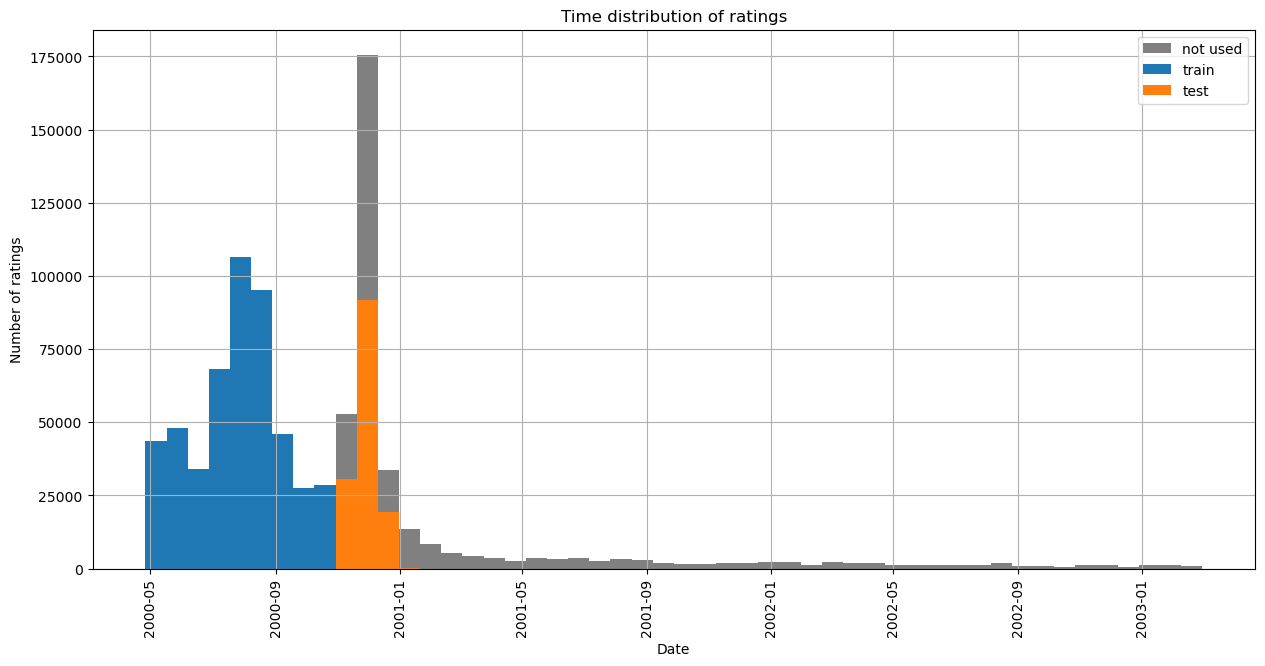

In [81]:
plt.figure(figsize=(15, 7))
plt.title("Time distribution of ratings")
plt.xlabel('Date')
plt.ylabel('Number of ratings')
_, bins  = np.histogram(ratings_mod.DateTime.map(lambda x: x.timestamp() / 60 / 60 / 24), 50)
not_used_ratings.DateTime.hist(bins=bins, label='not used', color='grey')
train_ratings.DateTime.hist(bins=bins, label='train')
test_ratings.DateTime.hist(bins=bins, label='test')

plt.xticks(rotation=90);
plt.legend();

In [82]:
new_test_users = test_ratings[~test_ratings.UserID.isin(train_ratings.UserID.unique())].UserID.unique()
new_test_movies = test_ratings[~test_ratings.MovieID.isin(train_ratings.MovieID.unique())].MovieID.unique()

print(f'Test set has {new_test_users.shape[0] / test_ratings.UserID.unique().shape[0]:.2%} of new users ({new_test_users.shape[0]})')
print(f'Test set has {new_test_movies.shape[0] / test_ratings.MovieID.unique().shape[0]:.2%} of new movies ({new_test_movies.shape[0]})')

Test set has 72.39% of new users (915)
Test set has 1.62% of new movies (55)


Save train / test ids for the evaluation framework

In [88]:
def save_ids(fn, df):
    """
    The function writes pairs of user and movie ids to a tab-separated file
    :param fn: filename
    :param df: pandas dataframe
    """
    with open(fn, 'w') as f:
        for _, r in df.iterrows():
            f.write(f"{r.UserID}\t{r.MovieID}\n")

In [87]:
save_ids(fn='../data/train.ids', df=train_ratings)
save_ids(fn='../data/test.ids', df=test_ratings)

In [89]:
! head ../data/train.ids

2779	3936
2779	1256
2779	2997
2779	589
2779	1
2779	1269
2779	1419
2779	1276
2779	1278
2779	1284


In [31]:
! head /Users/maksym/Downloads/title.basics.tsv


tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	4	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	12	Animation,Short
tt0000005	short	Blacksmith Scene	Blacksmith Scene	0	1893	\N	1	Comedy,Short
tt0000006	short	Chinese Opium Den	Chinese Opium Den	0	1894	\N	1	Short
tt0000007	short	Corbett and Courtney Before the Kinetograph	Corbett and Courtney Before the Kinetograph	0	1894	\N	1	Short,Sport
tt0000008	short	Edison Kinetoscopic Record of a Sneeze	Edison Kinetoscopic Record of a Sneeze	0	1894	\N	1	Documentary,Short
tt0000009	movie	Miss Jerry	Miss Jerry	0	1894	\N	45	Romance


In [53]:
imdb_title_basics = pd.read_csv('/Users/maksym/Downloads/title.basics.tsv', sep='\t', low_memory=False)

In [35]:
imdb_titles = set(imdb_title_basics.primaryTitle.to_list())

In [40]:
movies_mod

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
0,1,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2000
3879,3949,Requiem for a Dream,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3880,3950,Tigerland,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3881,3951,Two Family House,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000


In [71]:
def strip_the(x):
    if x.endswith(', The'):
        return x[:-5]
    return x


movies_mod.Title.map(lambda x: strip_the(x.strip()) in imdb_titles or x.strip() in imdb_titles).sum()

3075

In [72]:
movies_mod[~movies_mod.Title.map(lambda x: strip_the(x.strip()) in imdb_titles or x.strip() in imdb_titles)]

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
31,32,Twelve Monkeys,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1995
46,47,Seven (Se7en),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
57,58,"Postino, Il (The Postman)",0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1994
58,59,"Confessional, The (Le Confessionnal)",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3830,3900,Crime and Punishment in Suburbia,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3832,3902,Goya in Bordeaux (Goya en Bodeos),0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1999
3834,3904,"Uninvited Guest, An",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3850,3920,"Faraway, So Close (In Weiter Ferne, So Nah!)",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1993


In [73]:
titles1995 = imdb_title_basics[imdb_title_basics.startYear == '1995']

In [78]:
titles1995[titles1995.originalTitle.map(lambda x: 'monkeys' in x.lower())]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
108340,tt0110842,movie,The Plague Monkeys,The Plague Monkeys,0,1995,\N,60,Documentary
112133,tt0114746,movie,12 Monkeys,Twelve Monkeys,0,1995,\N,129,"Mystery,Sci-Fi,Thriller"
5927910,tt2336826,tvEpisode,Plague Monkeys,Plague Monkeys,0,1995,\N,\N,Documentary
8424631,tt6369972,tvEpisode,The Plague Monkeys,The Plague Monkeys,0,1995,\N,\N,Documentary


In [61]:
imdb_title_basics[imdb_title_basics.originalTitle == "Slumber Party Massacre II"]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
91910,tt0093996,movie,Slumber Party Massacre II,Slumber Party Massacre II,0,1987,\N,77,"Comedy,Horror,Musical"
2456295,tt12706590,tvEpisode,Slumber Party Massacre II,Slumber Party Massacre II,0,2015,\N,\N,Comedy
2570284,tt12921662,tvEpisode,Slumber Party Massacre II,Slumber Party Massacre II,0,2020,\N,121,"Comedy,Fantasy,Horror"
8157772,tt5768642,tvEpisode,Slumber Party Massacre II,Slumber Party Massacre II,0,2016,\N,20,Comedy
9969701,tt9755158,tvEpisode,Slumber Party Massacre II,Slumber Party Massacre II,0,2015,\N,\N,"Horror,Talk-Show"


In [44]:
'Toy Story' in imdb_titles

True

In [48]:
movies_mod[movies_mod.MovieID == 1].Title.iloc[0]

'Toy Story '

In [1]:
from evaluation.evaluation import EvaluationFramework

In [2]:
ef = EvaluationFramework()

In [3]:
ef.test_ratings

,UserID,MovieID,Rating,Timestamp
182,3,3421,4,978298147
183,3,1641,2,978298430
184,3,648,3,978297867
185,3,1394,4,978298147
186,3,3534,3,978297068
...,...,...,...,...
992322,5996,2805,4,975343775
992420,5996,3176,1,973091375
992696,5996,2718,3,976548278
992765,5996,3751,4,977932390


In [4]:
ef.train_ratings

,UserID,MovieID,Rating,Timestamp
451428,2779,3936,4,973021831
451433,2779,1256,5,973023015
451434,2779,2997,4,973022932
451435,2779,589,4,973021785
451436,2779,1,4,973023149
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [9]:
ratings.apply(lambda r: r.UserID == 1, axis=1)

0           True
1           True
2           True
3           True
4           True
           ...  
1000204    False
1000205    False
1000206    False
1000207    False
1000208    False
Length: 1000209, dtype: bool

In [3]:
! head ../data/train.ids

2779	3936
2779	1256
2779	2997
2779	589
2779	1
2779	1269
2779	1419
2779	1276
2779	1278
2779	1284


In [10]:
import requests

In [12]:
HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}


# Making a GET request
r = requests.get('https://www.imdb.com/title/tt0114746/', headers=HEADERS)
 
# print request object
print(r.url)
   
# print status code
print(r.status_code)

https://www.imdb.com/title/tt0114746/
200


In [13]:
r.text

'<!DOCTYPE html><html lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://www.facebook.com/2008/fbml"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><script>if(typeof uet === \'function\'){ uet(\'bb\', \'LoadTitle\', {wb: 1}); }</script><script>window.addEventListener(\'load\', (event) => {\n        if (typeof window.csa !== \'undefined\' && typeof window.csa === \'function\') {\n            var csaLatencyPlugin = window.csa(\'Content\', {\n                element: {\n                    slotId: \'LoadTitle\',\n                    type: \'service-call\'\n                }\n            });\n            csaLatencyPlugin(\'mark\', \'clickToBodyBegin\', 1690963661448);\n        }\n    })</script><title>Дванадцять мавп (1995) - IMDb</title><meta name="description" content="Дванадцять мавп: Directed by Terry Gilliam. With Joseph Melito, Bruce Willis, Jon Seda, Michael Chance. In a future world devastated by disease, a convict is sen

In [203]:
from bs4 import BeautifulSoup
import json
import html

In [15]:
soup = BeautifulSoup(r.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width" name="viewport"/>
  <script>
   if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }
  </script>
  <script>
   window.addEventListener('load', (event) => {
        if (typeof window.csa !== 'undefined' && typeof window.csa === 'function') {
            var csaLatencyPlugin = window.csa('Content', {
                element: {
                    slotId: 'LoadTitle',
                    type: 'service-call'
                }
            });
            csaLatencyPlugin('mark', 'clickToBodyBegin', 1690963661448);
        }
    })
  </script>
  <title>
   Дванадцять мавп (1995) - IMDb
  </title>
  <meta content="Дванадцять мавп: Directed by Terry Gilliam. With Joseph Melito, Bruce Willis, Jon Seda, Michael Chance. In a future world devastated by disease, a convict is sent back in 

In [24]:
soup.find_all('script type="application/ld+json')

[]

'Дванадцять мавп (1995) - IMDb'

In [27]:
data = json.loads(soup.find('script', type='application/ld+json').text)

In [29]:
data['description']

'In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.'

In [45]:
def get_movie_data(imdb_id):
    HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}
    r = requests.get(f'https://www.imdb.com/title/{imdb_id}/', headers=HEADERS)
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html.parser')
        ld_json = soup.find('script', type='application/ld+json')
        if ld_json:
            return json.loads(ld_json.text)

In [47]:
get_movie_data('tt0093996')

{'@context': 'https://schema.org',
 '@type': 'Movie',
 'url': 'https://www.imdb.com/title/tt0093996/',
 'name': 'Slumber Party Massacre II',
 'image': 'https://m.media-amazon.com/images/M/MV5BMjFjMTUyOTAtMDg4Yy00YjE4LWE1ODgtODM3ZDAwZWZhN2UyXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_.jpg',
 'description': 'Courtney Bates, the younger sister of Valerie, and her friends go to their condo for a weekend getaway, but Courtney can&apos;t get rid of the haunting feeling that a supernatural rockabilly driller killer is coming to murder them all.',
 'review': {'@type': 'Review',
  'itemReviewed': {'@type': 'Movie',
   'url': 'https://www.imdb.com/title/tt0093996/'},
  'author': {'@type': 'Person', 'name': 'Fella_shibby'},
  'dateCreated': '2021-03-21',
  'inLanguage': 'English',
  'name': 'Terrible n boring.',
  'reviewBody': 'I first saw this in the early 90s on a vhs. Revisited it recently. The actual movie is of 69 mins but the runtime is 76 mins with the start n end credits. The deal is, nothing happe

In [54]:
imdb_title_basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10044528,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10044529,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10044530,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10044531,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [63]:
movies_mod

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
0,1,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2000
3879,3949,Requiem for a Dream,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3880,3950,Tigerland,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3881,3951,Two Family House,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000


In [173]:
def map_movie_ids(imdb_df, movies_df):
    
    def strip_the(x):
        if x.endswith(', The'):
            return x[:-5]
        return x
        
    def start_with_the(x):
        if x.endswith(', The'):
            return 'The ' + x[:-5]
        return x    
    
    
    
    imdb_df = imdb_df.loc[(imdb_df.startYear != '\\N')].astype({'startYear': 'int64'}).copy()
    imdb_df.originalTitle = imdb_df.originalTitle.str.lower()
    imdb_df.primaryTitle = imdb_df.primaryTitle.str.lower()
    movies_df = movies_df[['MovieID', 'Title', 'Year']]
    
    res = {}
    for fn in [lambda x: x, strip_the, start_with_the]:
        for imdb_title_column in ['originalTitle', 'primaryTitle']:

            movies_df_filtered = movies_df[~movies_df.MovieID.isin(res)].copy()
            movies_df_filtered['Title'] = movies_df_filtered['Title'].str.strip().map(fn).str.lower()

            merged = pd.merge(imdb_df, movies_df_filtered,  how='inner', left_on=[imdb_title_column, 'startYear'], right_on = ['Title', 'Year'])[['tconst', 'titleType', 'MovieID']]
            # deal with duplicates
            for movie_id, data in merged.groupby('MovieID'):
                if data.shape[0] == 1:
                    res[movie_id] = data.tconst.iloc[0]
                else:
                    for t in ['movie', 'tvMovie', 'tvSeries', 'tvMiniSeries', 'tvEpisode', 'short', 'tvShort', 'tvSpecial', 'video', 'tvPilot']:
                        data_filtered = data[data.titleType == t]
                        if data_filtered.shape[0] > 0:
                            res[movie_id] = data_filtered.tconst.iloc[0]
                            break

        
        
    
    return res

In [177]:
mapped_movie_ids = map_movie_ids(
    imdb_df=imdb_title_basics, 
    movies_df=movies_mod
)

In [178]:
mapped_movie_ids

{1: 'tt0114709',
 2: 'tt0113497',
 3: 'tt0113228',
 4: 'tt0114885',
 5: 'tt0113041',
 6: 'tt0113277',
 7: 'tt0114319',
 8: 'tt0112302',
 9: 'tt0114576',
 10: 'tt0113189',
 12: 'tt0112896',
 13: 'tt0112453',
 14: 'tt0113987',
 15: 'tt0112760',
 16: 'tt0112641',
 17: 'tt0114388',
 18: 'tt0113101',
 19: 'tt0112281',
 20: 'tt0113845',
 21: 'tt0113161',
 22: 'tt0112722',
 23: 'tt0112401',
 24: 'tt0114168',
 25: 'tt0113627',
 26: 'tt0114057',
 27: 'tt0114011',
 28: 'tt26933001',
 31: 'tt0112792',
 32: 'tt0114746',
 33: 'tt0114952',
 34: 'tt0112431',
 35: 'tt0112637',
 36: 'tt0112818',
 37: 'tt0112286',
 38: 'tt0113442',
 39: 'tt0112697',
 40: 'tt0112749',
 41: 'tt0114279',
 42: 'tt0112819',
 43: 'tt0114272',
 44: 'tt0113855',
 45: 'tt0114681',
 46: 'tt0113347',
 48: 'tt0114148',
 49: 'tt0114916',
 51: 'tt0559192',
 52: 'tt0113819',
 53: 'tt0110299',
 55: 'tt0113158',
 56: 'tt0113541',
 57: 'tt0113321',
 61: 'tt0116260',
 62: 'tt0113862',
 63: 'tt0116126',
 64: 'tt0118002',
 65: 'tt0115683',


In [183]:
get_movie_data('tt0114122').get('description')

'During the American Civil War, a Union Army captain leads his rag-tag cavalry troop up a misty creek to a remote farm to appropriate enemy (Confederate) livestock. The farm is worked by Sarah Anders, whose husband is away fighting...'

In [182]:
movies_mod[movies_mod.MovieID == 777]

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
767,777,Pharaoh's Army,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1995


In [187]:
descriptions = {}

for i, (k, v) in enumerate(mapped_movie_ids.items()):
    
    for _ in range(3):  # retry 3 times
        movie_data = get_movie_data(v)
        if movie_data is not None:
            descriptions[k] = movie_data.get('description')
            break
    
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [189]:
len(descriptions)

3131

In [200]:
len([k for k, v in descriptions.items() if v is not None])

3105

In [196]:
len([k for k, v in descriptions.items() if (v is not None) and ('::' in v)])

0

In [197]:
! head ../data/movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [204]:
with open('../data/movie_descriptions.dat', 'w') as f:
    for k, v in descriptions.items():
        if v is not None:
            f.write(f"{k}::{html.unescape(v)}\n")

In [205]:
! head ../data/movie_descriptions.dat

1::A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy's bedroom.
2::When two kids find and play a magical board game, they release a man trapped in it for decades - and a host of dangers that can only be stopped by finishing the game.
3::John and Max resolve to save their beloved bait shop from turning into an Italian restaurant, just as its new female owner catches Max's attention.
4::Based on Terry McMillan's novel, this film follows four very different African-American women and their relationships with men.
5::George Banks must deal not only with his daughter's pregnancy, but also with his wife's.
6::A group of high-end professional thieves start to feel the heat from the LAPD when they unknowingly leave a clue at their latest heist.
7::An ugly duckling having undergone a remarkable change, still harbors feelings for her crush: a carefree playboy, but not before his business-focused brother has something to say abo

In [202]:
html.unescape('A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy&apos;s bedroom.')

"A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy's bedroom."

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [207]:
tfidf = TfidfVectorizer(stop_words='english')

In [210]:
tfidf_matrix = tfidf.fit_transform(list(descriptions.values())[:20])

In [216]:
tfidf_matrix.toarray().shape

(20, 245)

In [217]:
len(tfidf.get_feature_names_out())

245

In [215]:
list(descriptions.values())[:20]

['A cowboy doll is profoundly threatened and jealous when a new spaceman action figure supplants him as top toy in a boy&apos;s bedroom.',
 'When two kids find and play a magical board game, they release a man trapped in it for decades - and a host of dangers that can only be stopped by finishing the game.',
 'John and Max resolve to save their beloved bait shop from turning into an Italian restaurant, just as its new female owner catches Max&apos;s attention.',
 'Based on Terry McMillan&apos;s novel, this film follows four very different African-American women and their relationships with men.',
 'George Banks must deal not only with his daughter&apos;s pregnancy, but also with his wife&apos;s.',
 'A group of high-end professional thieves start to feel the heat from the LAPD when they unknowingly leave a clue at their latest heist.',
 'An ugly duckling having undergone a remarkable change, still harbors feelings for her crush: a carefree playboy, but not before his business-focused br

In [218]:
movies_mod

,MovieID,Title,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,...,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western,Year
0,1,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2000
3879,3949,Requiem for a Dream,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3880,3950,Tigerland,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000
3881,3951,Two Family House,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2000


In [220]:
from evaluation.read_data import add_movie_descriptions

ImportError: cannot import name 'add_movie_descriptions' from 'evaluation.read_data' (/Users/maksym/UCU/recommender-systems-project/evaluation/read_data.py)

In [ ]:
class CollaborativeRecommender(AbstractModel):

    def __init__(self, users, movies):
        super().__init__(users, movies)
        self.matrix = None
        self.similarity_mtx = None

    def fit(self, X, y):
        X['Rating'] = y
        matrix = pd.pivot_table(X, index='MovieID', columns='UserID', values='Rating')
        matrix = matrix.fillna(0)

        distance_mtx = squareform(pdist(matrix, 'cosine'))
        similarity_mtx = 1 - distance_mtx

        self.matrix = matrix
        self.similarity_mtx = similarity_mtx


    def predict(self, X):
        user_ids = X['UserID'].values
        movie_ids = X['MovieID'].values

        predicted_ratings = np.zeros(len(X))

        for i in range(len(X)):
            user_rating = self.matrix.iloc[:, user_ids[i] - 1]
            movie_similarity = self.similarity_mtx[movie_ids[i] - 1]

            numerator = np.dot(user_rating, movie_similarity)
            denomination = movie_similarity[user_rating > 0].sum()
            predicted_ratings[i] = numerator / denomination

        return predicted_ratings

In [236]:
users_mod

,UserID,Gender,Age,Occupation,ZipCode,AgeGroup,OccupationDetailed
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer
...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,25-34,scientist
6036,6037,F,45,1,76006,45-49,academic/educator
6037,6038,F,56,1,14706,56+,academic/educator
6038,6039,F,45,0,01060,45-49,other or not specified


In [260]:
aa = pd.get_dummies(users_mod[['Occupation', 'Gender']], columns=['Occupation', 'Gender'], prefix=['occupation', 'gender'])

In [261]:
aa

,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,...,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20,gender_F,gender_M
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6036,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6037,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6038,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [247]:
pd.get_dummies(users_mod.Occupation, prefix='occupation')

,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,...,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6036,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [263]:
users_mod.set_index('UserID')

,Gender,Age,Occupation,ZipCode,AgeGroup,OccupationDetailed
UserID,,,,,,
1,F,1,10,48067,Under 18,K-12 student
2,M,56,16,70072,56+,self-employed
3,M,25,15,55117,25-34,scientist
4,M,45,7,02460,45-49,executive/managerial
5,M,25,20,55455,25-34,writer
...,...,...,...,...,...,...
6036,F,25,15,32603,25-34,scientist
6037,F,45,1,76006,45-49,academic/educator
6038,F,56,1,14706,56+,academic/educator


In [264]:
users_mod

,UserID,Gender,Age,Occupation,ZipCode,AgeGroup,OccupationDetailed
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer
...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,25-34,scientist
6036,6037,F,45,1,76006,45-49,academic/educator
6037,6038,F,56,1,14706,56+,academic/educator
6038,6039,F,45,0,01060,45-49,other or not specified


In [239]:
aa.columns = [f'occupation_{x}' for x in aa.columns]

In [241]:
aa['Gender'] = users_mod.Gender.map({'M': 0, 'F': 1})

In [243]:
aa['Age'] = users_mod.Age

In [249]:
aa

,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,...,occupation_11,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6036,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
aa

,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,...,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20,Gender,Age
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,56
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,25
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,45
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,25
6036,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,45
6037,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,56
6038,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,45


In [267]:
pd.get_dummies(users_mod.set_index('UserID')[['Occupation', 'Gender', 'Age']],
                                   columns=['Occupation', 'Gender'], prefix=['occupation', 'gender'], dtype=int)

,Age,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,...,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20,gender_F,gender_M
UserID,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,56,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,25,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,45,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,25,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
6037,45,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6038,56,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
